# Applicazione di Sift per combinare 2 immagini

In [1]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

%matplotlib inline

Obiettivo è quello di combinare due immagini in un'unica immagine facendo combiaciare le parti corrrispondenti

La strategia è quella di individuare i keypoints, trovare le corrispondenze tra l'immagine A e quella B e poi effettuare le opportune trasformazioni per effettuare il merge

Utilizziamo l'implementazione OpenCV

In [2]:
SIFT = cv2.xfeatures2d.SIFT_create()

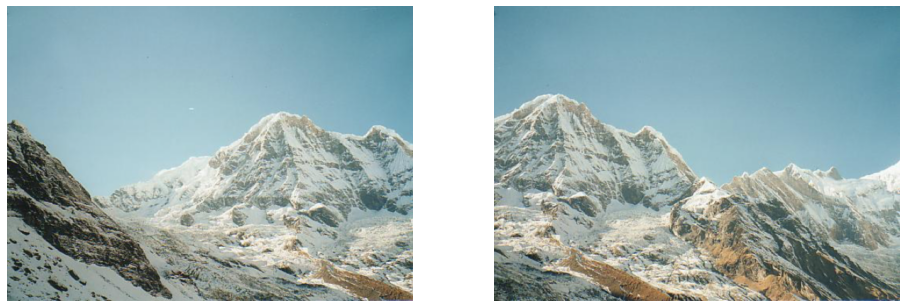

In [3]:
# Images

image_left = cv2.cvtColor(cv2.imread('mountain_view1.png'), cv2.COLOR_BGR2RGB)
image_right = cv2.cvtColor(cv2.imread('mountain_view2.png'), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes = axes.ravel()

for i, mx in enumerate((image_left, image_right)):
    axes[i].imshow(mx)
    axes[i].axis('off')
         
plt.show()

## Analizziamo l'immagine A

In [4]:
image_left_gray = cv2.cvtColor(image_left, cv2.COLOR_RGB2GRAY)

keypoints_left, descriptors_left = SIFT.detectAndCompute(image_left_gray, None)

len(keypoints_left)

2233

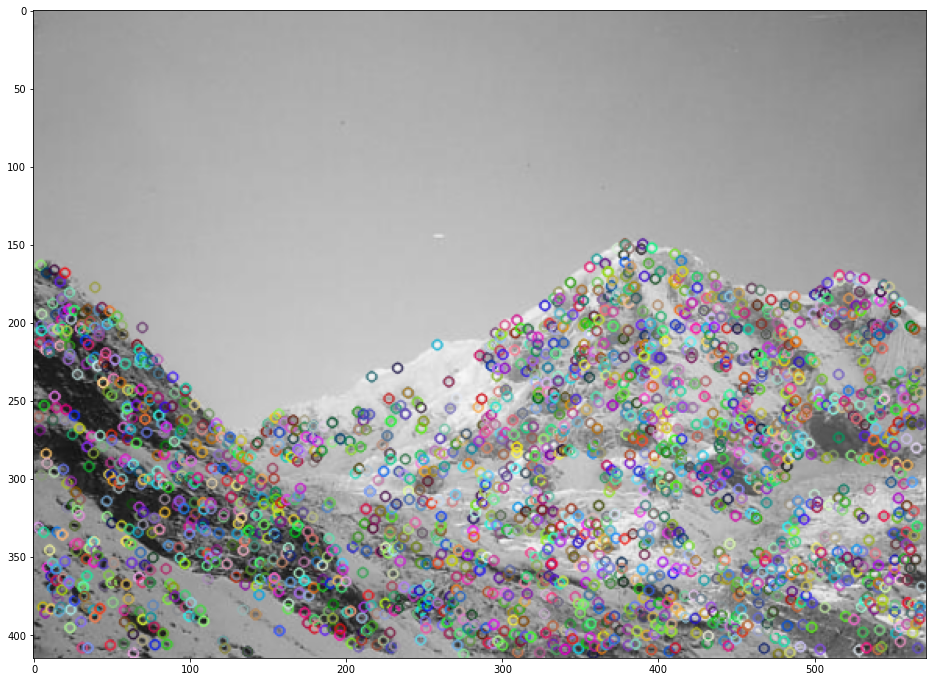

In [5]:
img_2 = cv2.drawKeypoints(image_left_gray, keypoints_left, image_left.copy())


plt.figure(figsize=(16, 12))
plt.imshow(img_2);

## Analizziamo l'immagine B

In [6]:
image_right_gray = cv2.cvtColor(image_right, cv2.COLOR_RGB2GRAY)

keypoints_right, descriptors_right = SIFT.detectAndCompute(image_right_gray, None)

len(keypoints_right)

2364

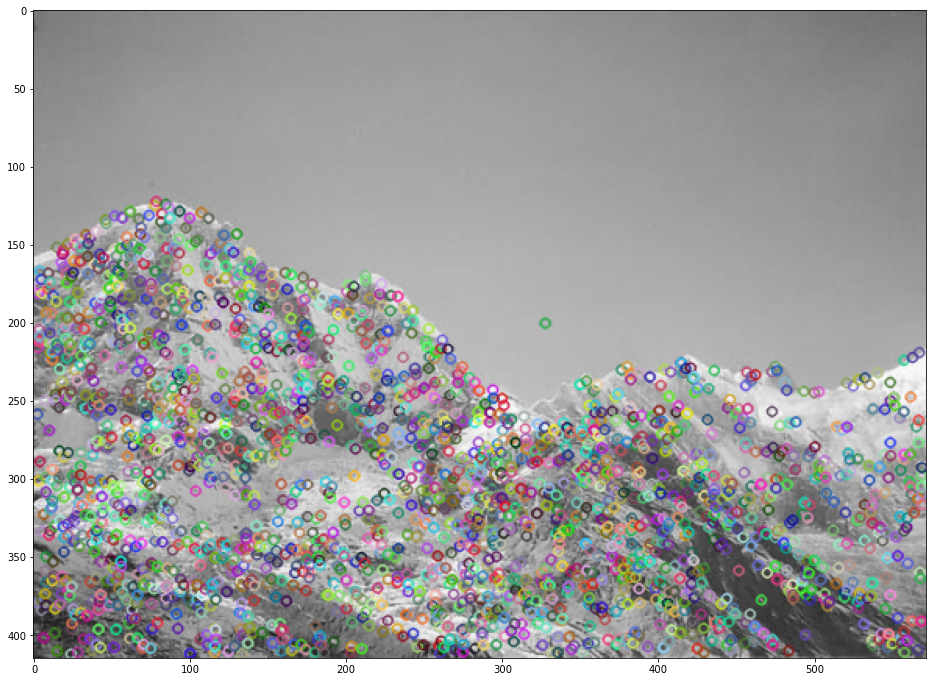

In [7]:
img_2_right = cv2.drawKeypoints(image_right_gray, keypoints_right, image_right.copy())


plt.figure(figsize=(16, 12))
plt.imshow(img_2_right);

## Combiniamo le immagini

1. Si individuano le corrispondenze tra i keypoint di A e di B
2. Si trasforma l'immagine B e si effettua il merge

Per individuare la corrispondenza si può utilizzare un algoritmo basato sul criterio di distanza euclidea per individuare le coppie di keypoints $(kp_A, kp_B)$.

Per ogni punto si individuano i *k* punti *più vicini* al punto candidato. Si itera finché non si raggiunge una configurazione ottimale o si raggiunge il numero massimo di iterazioni.

Al termine del processo, si può effettuare una raffinamento del risultato eliminando le coppie con un valore di distanza *elevato*.

In [8]:
ratio = .75

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

matches = bf.knnMatch(descriptors_right, descriptors_left, k=2)

good = []
# loop over the raw matches
for m,n in matches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
    if m.distance < n.distance * ratio:
        good.append(m)
matches = np.asarray(good)

matches.shape

(507,)

visualizziamo la corrispondenza di 100 punti tra tutti quelli individuati

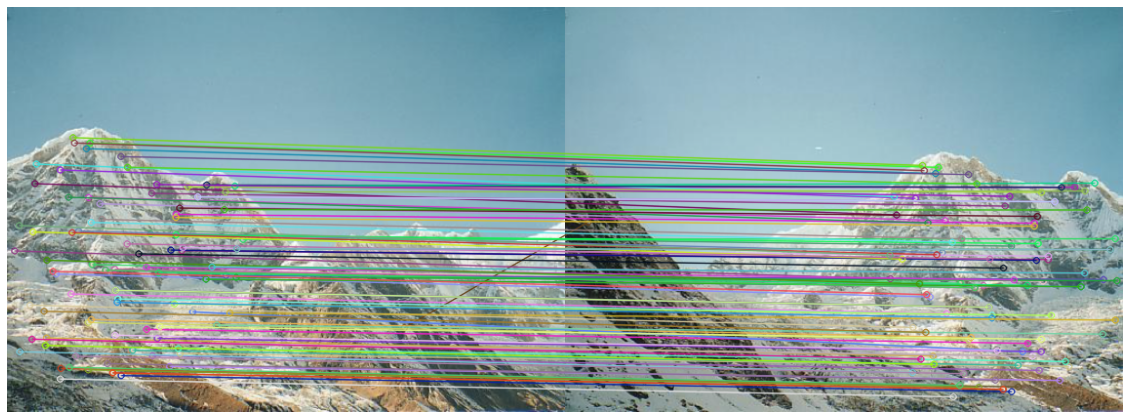

In [9]:
matches_sublist = np.random.choice(matches.flatten(), 100)

img_desc = cv2.drawMatches(image_right, keypoints_right, image_left, keypoints_left, 
                           matches_sublist,
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.figure(figsize=(20, 12))
plt.imshow(img_desc)
plt.axis('off')
plt.show()

In [10]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return H, status
    else:
        raise RuntimeError('Can’t find enough keypoints.')
    
    
H, status = getHomography(keypoints_right, keypoints_left, 
                          descriptors_right, descriptors_left,
                          matches, 3)
    
H    

array([[ 5.85906129e-01,  1.35164619e-01,  2.86311568e+02],
       [-2.87162461e-01,  8.63817547e-01,  5.74333650e+01],
       [-6.75039532e-04, -8.56668196e-05,  1.00000000e+00]])

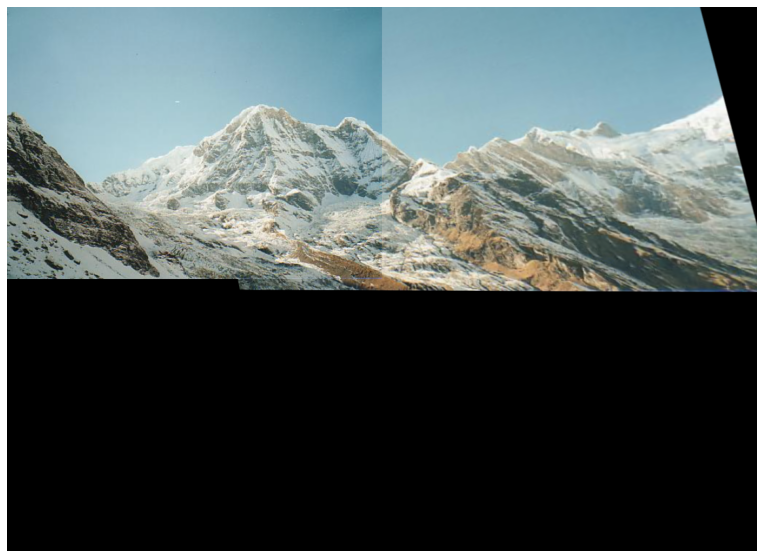

In [11]:
# Apply panorama correction
width = image_left.shape[1] + image_right.shape[1]
height = image_left.shape[0] + image_right.shape[0]

result = cv2.warpPerspective(image_right, H, (width, height))
#result[0:image_right.shape[0], 0:image_right.shape[1]] = image_right
result[0:image_left.shape[0], 0:image_left.shape[1]] = image_left

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

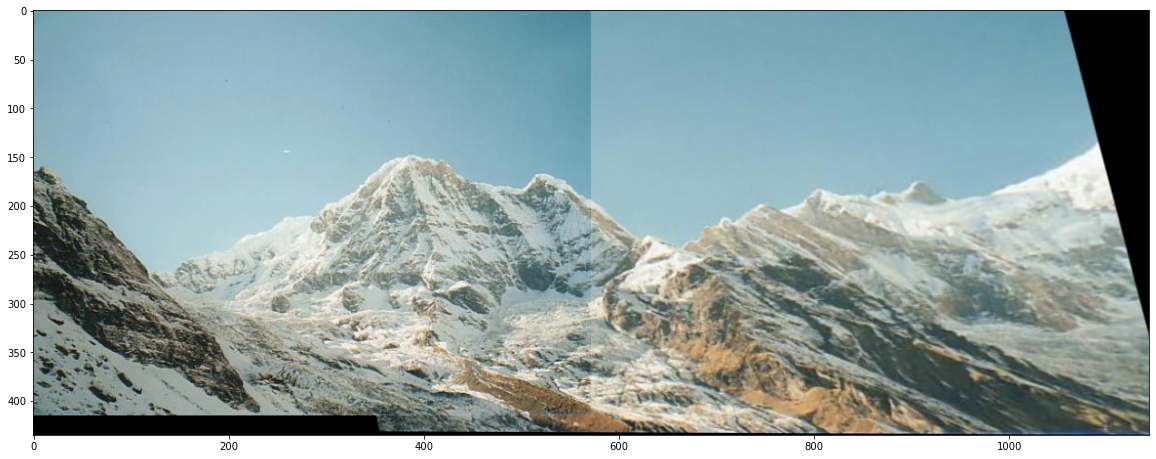

In [12]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result);

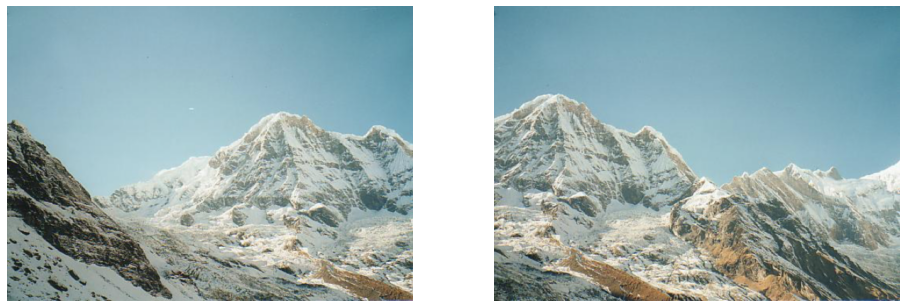

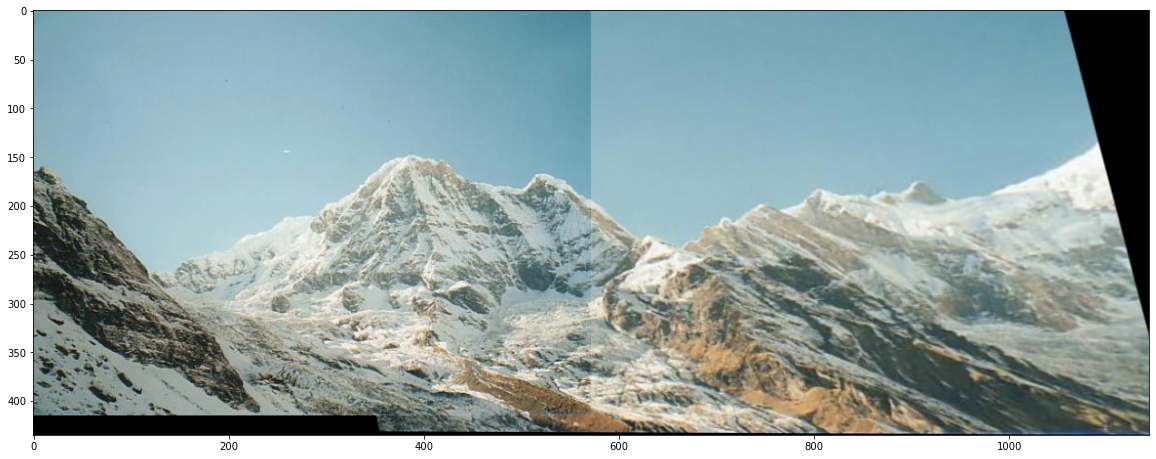

In [13]:
# Images
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes = axes.ravel()

for i, mx in enumerate((image_left, image_right)):
    axes[i].imshow(mx)
    axes[i].axis('off')

    
plt.figure(figsize=(20,10))
plt.imshow(result);
    
plt.show()